<a href="https://colab.research.google.com/github/AndrejNasteski/MachineVision/blob/main/Machine_Vision_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from IPython.display import HTML
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import adam_v2
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import PIL
import numpy.random as rng
import numpy as np
import os
import cv2
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import pandas as pd
%matplotlib inline

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd gdrive
%cd MyDrive/Colab\ Notebooks
%cd MV Project


/content/gdrive
/content/gdrive/MyDrive/Colab Notebooks
/content/gdrive/MyDrive/Colab Notebooks/MV Project


In [4]:
IMAGE_SHAPE = (256, 256, 3)
EPOCHS=50
BATCH_SIZE = 64
MARGIN = 1
OUTPUT_PATH = "output"
MODEL_PATH = os.path.sep.join([OUTPUT_PATH, "siamese_model_6"])
PLOT_PATH = os.path.sep.join([OUTPUT_PATH, "plot.png"])


DATASET_BATCH_SIZE = 9
PATH = '/content/grdive/My Drive/Notebooks/MV Project'

In [7]:
def load_dataset(directory):
  dataset = []
  class_directories = os.listdir(directory)
  i = 0
  for class_path in class_directories:
    image_list = os.listdir(directory + "/" + class_path)

    for image_path in image_list:
      img=cv2.imread(directory + "/" + class_path + "/" + image_path)
      img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      img_array = np.array(img)

      dataset.append(np.array([img, i]))

    i += 1
  dataset = np.array(dataset)
  np.random.shuffle(dataset)
  return dataset

Loads the image dataset into an numpy array of size 150 images.
Image shape is 256, 256, 3.

In [8]:
directory = "PlantVillagePotatoShort"

image_dataset = load_dataset(directory)

train_dataset = image_dataset[:int(len(image_dataset) * 0.8)]
test_dataset = image_dataset[int(len(image_dataset) * 0.8):]

train_dataset = np.swapaxes(train_dataset, 0, 1)
test_dataset = np.swapaxes(test_dataset, 0, 1)

train_images = train_dataset[0]
train_labels = train_dataset[1]

test_images = test_dataset[0]
test_labels = test_dataset[1]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


Split the dataset into train and test images. Split ratio: train 80%, test 20%.

In [9]:
# make pairs after splitting the dataset

def make_pairs(images, labels):
  pair_images = []
  pair_labels = []

  NUM_CLASSES = len(np.unique(labels))
  idx = [np.where(labels == i)[0] for i in range(0, NUM_CLASSES)]
  # list of indexes of all samples labeled as class 'i'
  # the first element has indexes of samples with class 0

  for idxA in range(len(images)):
    current_image = images[idxA]
    label = labels[idxA]

    idxB = np.random.choice(idx[label]) 
    # pick a random image from the same class
    pos_image = images[idxB]

    pair_images.append([current_image, pos_image])
    pair_labels.append([1])

    neg_idx = np.where(labels != label)[0]
    # grab the indexes of images from a different class
    neg_image = images[np.random.choice(neg_idx)] # grab a random image

    pair_images.append([current_image, neg_image])
    pair_labels.append([0])

  return np.array(pair_images), np.array(pair_labels)


Makes pairs of images for training and testing. Each image is paired with one image from the same class and one from a different class.

In [16]:
def euclidean_distance(vectors):
  (features_A, features_B) = vectors
  sum_squared = K.sum(K.square(features_A - features_B), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_squared, K.epsilon()))

def plot_training(H, plot_path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H.history["loss"], label="train_loss")
  plt.plot(H.history["val_loss"], label="val_loss")
  plt.plot(H.history["accuracy"], label="train_acc")
  plt.plot(H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")
  plt.savefig(plot_path)

In [10]:
train_pair_images, train_pair_labels = make_pairs(train_images, train_labels)
test_pair_images, test_pair_labels = make_pairs(test_images, test_labels)

In [18]:
feature_model = Sequential([
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    Dropout(0.4),
    layers.Flatten(),
    layers.Dense(4, activation='relu')
])

In [19]:
img_A = Input(shape=IMAGE_SHAPE)
img_B = Input(shape=IMAGE_SHAPE)

convnet = feature_model

feat_A = convnet(img_A)
feat_B = convnet(img_B)

distance = Lambda(euclidean_distance)([feat_A, feat_B])
normal_layer = tf.keras.layers.BatchNormalization()(distance)
output_layer = Dense(1, activation="sigmoid")(normal_layer)
model = Model(inputs=[img_A, img_B], outputs=output_layer)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_3 (Sequential)      (None, 4)            71164       ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

[INFO] compiling model...
[INFO] training model...
Epoch 1/50
4/4 - 101s - loss: 0.7548 - accuracy: 0.5375 - val_loss: 0.7000 - val_accuracy: 0.5000 - 101s/epoch - 25s/step
Epoch 2/50
4/4 - 91s - loss: 0.7843 - accuracy: 0.5042 - val_loss: 0.7007 - val_accuracy: 0.5000 - 91s/epoch - 23s/step
Epoch 3/50
4/4 - 89s - loss: 0.8029 - accuracy: 0.4750 - val_loss: 0.8275 - val_accuracy: 0.6333 - 89s/epoch - 22s/step
Epoch 4/50
4/4 - 89s - loss: 0.7849 - accuracy: 0.5000 - val_loss: 0.7487 - val_accuracy: 0.5667 - 89s/epoch - 22s/step
Epoch 5/50
4/4 - 90s - loss: 0.7628 - accuracy: 0.5292 - val_loss: 0.6836 - val_accuracy: 0.6500 - 90s/epoch - 23s/step
Epoch 6/50
4/4 - 89s - loss: 0.7836 - accuracy: 0.4958 - val_loss: 0.6623 - val_accuracy: 0.6833 - 89s/epoch - 22s/step
Epoch 7/50
4/4 - 89s - loss: 0.7188 - accuracy: 0.5333 - val_loss: 0.6757 - val_accuracy: 0.6500 - 89s/epoch - 22s/step
Epoch 8/50
4/4 - 92s - loss: 0.7728 - accuracy: 0.5208 - val_loss: 0.6575 - val_accuracy: 0.6000 - 92s/epoc

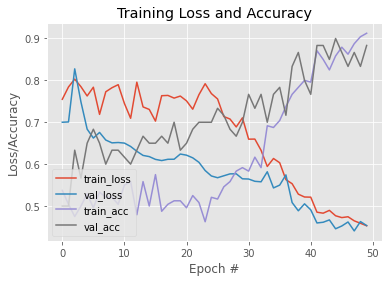

In [ ]:
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
print("[INFO] training model...")
history = model.fit(
	[train_pair_images[:, 0], train_pair_images[:, 1]], train_pair_labels[:],
	validation_data=([test_pair_images[:, 0], test_pair_images[:, 1]], test_pair_labels[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	verbose = 2)
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)